<a href="https://colab.research.google.com/github/worldone-web/Team4-Traveler/blob/main/NCF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)


Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
import torch
import numpy as np
import pandas as pd
import random
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("PyTorch version:", torch.__version__)

CUDA available: True
CUDA version: 12.1
PyTorch version: 2.5.0+cu121


In [ ]:
root_path = '/content/drive/MyDrive/BPR/'

train_checkin = root_path + 'train.csv'
test_checkin = root_path + 'test.csv'
test_negative = root_path + 'negative.csv'

## 데이터 생성

In [ ]:
df = pd.read_csv(root_path + "philadelphia_checkin_small.csv")
df.head()

,newUserId,newBusinessId
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


### split_train_test

In [ ]:
# 각 사용자별로 n번째 음식점 방문기록 까지 데이터를 테스트 데이터로, 나머지를 트레이닝 데이터로 분리하는 함수
def split_train_test_data(df, n=3, user_col='newUserId', item_col='newBusinessId', output_dir='.'):
    train_data = []
    test_data = []

    # 사용자별로 그룹화하여 처리
    for user_id, group in df.groupby(user_col):
        # 첫 번째부터 n번째 음식점 방문 기록을 test_data로 추가
        test_data.extend(group.iloc[:n].values.tolist())

        # n+1번째부터 마지막 음식점 방문 기록을 train_data로 추가
        train_data.extend(group.iloc[n:].values.tolist())

    train_df = pd.DataFrame(train_data, columns=[user_col, item_col])
    test_df = pd.DataFrame(test_data, columns=[user_col, item_col])


    train_size = train_df.shape
    test_size = test_df.shape
    print("Train 데이터 크기:", train_size)
    print("Test 데이터 크기:", test_size)
    print("Test 데이터 크기 / Train 데이터 크기 비율:", test_size[0] / train_size[0]) # 전체 크기의 대략 10%

    # CSV 파일로 저장
    train_df.to_csv(output_dir + "train.csv", index=False, header=False, sep='\t')
    test_df.to_csv(output_dir + "test.csv", index=False, header=False, sep='\t')

    print("'train.csv'와 'test.csv' 파일이 생성되었습니다.")

split_train_test_data(df, n=3, output_dir=root_path)

Train 데이터 크기: (296794, 2)
Test 데이터 크기: (36185, 2)
Test 데이터 크기 / Train 데이터 크기 비율: 0.12191958058451316
'train.csv'와 'test.csv' 파일이 생성되었습니다.


### generate_negative

In [ ]:
# 각 사용자별로 부정적인 조합 생성
def generate_negative_samples(df, n=100, user_col='newUserId', item_col='newBusinessId', output_dir='.'):
    # 사용자와 음식점 집합 구하기
    users = df[user_col].unique()
    businesses = df[item_col].unique()

    # 사용자별로 부정적인 조합 저장
    user_negative_samples = {}

    # 각 사용자에 대해 부정적인 조합 생성
    for user in users:
        # 사용자가 방문한 음식점 집합
        user_visited_businesses = set(df[df[user_col] == user][item_col].unique())

        # 사용자가 방문하지 않은 음식점 찾기
        user_not_visited_businesses = list(set(businesses) - user_visited_businesses)

        # 랜덤 샘플링하여 부정적인 조합 생성
        if len(user_not_visited_businesses) > n: #n개 이상이면 데이터가 많아지니 제한을 둠
            user_negative_samples[user] = random.sample(user_not_visited_businesses, n)
        else:
            user_negative_samples[user] = user_not_visited_businesses

    # 부정적인 조합을 CSV 파일로 저장
    with open(output_dir+ "negative.csv", 'w') as f:
        for user, negatives in user_negative_samples.items():
            f.write(f"{user},{','.join(map(str, negatives))}\n")

    print("파일 'negative.csv'가 생성되었습니다.")

generate_negative_samples(df, n=100, output_dir=root_path)

파일 'negative.csv'가 생성되었습니다.


### generate_individual_negative

In [ ]:
# 각 사용자별로 부정적인 조합 생성
def generate_negative_samples(df, n=100, user_col='newUserId', item_col='newBusinessId', output_dir='.'):
    # 사용자와 음식점 집합 구하기
    users = df[user_col].unique()
    businesses = df[item_col].unique()

    # 사용자별로 부정적인 조합 저장
    user_negative_samples = {}

    # 각 사용자에 대해 부정적인 조합 생성
    for user in users:
        # 사용자가 방문한 음식점 집합
        user_visited_businesses = set(df[df[user_col] == user][item_col].unique())

        # 사용자가 방문하지 않은 음식점 찾기
        user_not_visited_businesses = list(set(businesses) - user_visited_businesses)

        # 랜덤 샘플링하여 부정적인 조합 생성
        if len(user_not_visited_businesses) > n: #n개 이상이면 데이터가 많아지니 제한을 둠
            user_negative_samples[user] = random.sample(user_not_visited_businesses, n)
        else:
            user_negative_samples[user] = user_not_visited_businesses

    # 부정적인 조합을 CSV 파일로 저장
    with open(output_dir+ "negative.csv", 'w') as f:
        for user, negatives in user_negative_samples.items():
            f.write(f"{user},{','.join(map(str, negatives))}\n")

    print("파일 'negative.csv'가 생성되었습니다.")

generate_negative_samples(df, n=100, output_dir=root_path)

## 모델 생성

### 평가함수

In [ ]:
def hit(gt_item, pred_items):
	if gt_item in pred_items:
		return 1
	return 0


def ndcg(gt_item, pred_items):
	if gt_item in pred_items:
		index = pred_items.index(gt_item)
		return np.reciprocal(np.log2(index+2))
	return 0


def metrics(model, test_loader, top_k):
	# HR: 전체 사용자 수 대비 적중한 사용자 수
	# NDCG: '사용자'와 '추천한 아이템'의 '관련성'에 대해 추천 순서에 따라 가중치를 주어 합한뒤 정규화한 것
	HR, NDCG = [], []

	for user, item_i, item_j in test_loader:
		user = user.cuda()
		item_i = item_i.cuda()
		item_j = item_j.cuda() # not useful when testing

		prediction_i, prediction_j = model(user, item_i, item_j)
		_, indices = torch.topk(prediction_i, top_k)
		recommends = torch.take(
				item_i, indices).cpu().numpy().tolist()

		gt_item = item_i[0].item()
		HR.append(hit(gt_item, recommends))
		NDCG.append(ndcg(gt_item, recommends))

	return np.mean(HR), np.mean(NDCG)

### 모델

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import os
import time
import numpy as np
import torch.backends.cudnn as cudnn

import pandas as pd
import scipy.sparse as sp
import random
import torch.utils.data as data

In [ ]:
# 하드코딩된 기본값 설정
lr = 0.001
lamda = 0.001
batch_size = 4096
epochs = 100
top_k = 10
num_factors = 32
num_ng = 4
test_num_ng = 99
out = True

In [ ]:

class NCFData(Dataset):
    def __init__(self, features, num_item, train_mat=None, num_ng=0, is_training=None):
        super(NCFData, self).__init__()
        self.features = features
        self.num_item = num_item
        self.train_mat = train_mat
        self.num_ng = num_ng
        self.is_training = is_training
        self.features_fill = []

        if self.is_training:
            self.ng_sample()

    def ng_sample(self):
        assert self.is_training, 'no need to sampling when testing'
        for x in self.features:
            u, i = x[0], x[1]
            for t in range(self.num_ng):
                j = np.random.randint(self.num_item)
                while (u, j) in self.train_mat:
                    j = np.random.randint(self.num_item)
                self.features_fill.append([u, i, j])

    def __len__(self):
        return self.num_ng * len(self.features) if self.is_training else len(self.features)

    def __getitem__(self, idx):
        features = self.features_fill if self.is_training else self.features
        user = features[idx][0]
        item_i = features[idx][1]
        item_j = features[idx][2] if self.is_training else features[idx][1]
        return user, item_i, item_j


class NCF(nn.Module):
    def __init__(self, num_users, num_items, num_factors=32):
        super(NCF, self).__init__()
        self.user_factors = nn.Embedding(num_users, num_factors)
        self.item_factors = nn.Embedding(num_items, num_factors)

        self.fc1 = nn.Linear(num_factors * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

        self.relu = nn.ReLU()

    def forward(self, user_ids, item_ids_i, item_ids_j):
        user_embedding = self.user_factors(user_ids)
        item_embedding_i = self.item_factors(item_ids_i)
        item_embedding_j = self.item_factors(item_ids_j)


        combined_i = torch.cat([user_embedding, item_embedding_i], dim=-1)
        combined_j = torch.cat([user_embedding, item_embedding_j], dim=-1)


        hidden_i = self.relu(self.fc1(combined_i))
        hidden_j = self.relu(self.fc1(combined_j))

        hidden_i = self.relu(self.fc2(hidden_i))
        hidden_j = self.relu(self.fc2(hidden_j))


        pred_i = self.fc3(hidden_i).squeeze()
        pred_j = self.fc3(hidden_j).squeeze()

        return pred_i, pred_j

### 데이터셋 준비

In [ ]:
def load_all():
    # 데이터 로드 및 전처리
    train_data = pd.read_csv(train_checkin, sep='\t', header=None, names=['user', 'item'],
                             usecols=[0, 1], dtype={0: np.int32, 1: np.int32})

    user_num = train_data['user'].max() + 1
    item_num = train_data['item'].max() + 1
    train_data = train_data.values.tolist()

    train_mat = sp.dok_matrix((user_num, item_num), dtype=np.float32)
    for x in train_data:
        train_mat[x[0], x[1]] = 1.0

    test_data = []
    with open(test_negative, 'r') as fd:
        line = fd.readline()
        while line:
            arr = line.split('\t')
            u = eval(arr[0])[0]
            test_data.append([u, eval(arr[0])[1]])
            for i in arr[1:]:
                test_data.append([u, int(i)])
            line = fd.readline()

    return train_data, test_data, user_num, item_num, train_mat

################# 데이터셋 준비 ##################
train_data, test_data, user_num, item_num, train_mat = load_all()

train_dataset = NCFData(train_data, item_num, train_mat, num_ng, True)
test_dataset = NCFData(test_data, item_num, train_mat, 0, False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=test_num_ng + 1, shuffle=False, num_workers=0)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### 모델 생성

In [ ]:
# 모델 초기화
model = NCF(user_num, item_num, num_factors)
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=lr)

### 훈련

In [ ]:
########################### 훈련 #####################################
records_hr = []
records_ngcg = []


# 손실 함수
def ncf_loss(pred_i, pred_j):
    return - (pred_i - pred_j).sigmoid().log().mean()


count, best_hr = 0, 0
for epoch in range(epochs):
    model.train()
    start_time = time.time()
    train_loader.dataset.ng_sample()

    for user, item_i, item_j in train_loader:
        user = user.cuda()
        item_i = item_i.cuda()
        item_j = item_j.cuda()

        model.zero_grad()
        prediction_i, prediction_j = model(user, item_i, item_j)

        # 손실 계산
        loss = ncf_loss(prediction_i, prediction_j)

        # 역전파 및 파라미터 업데이트
        loss.backward()
        optimizer.step()

        count += 1

    # 성능 평가 및 출력
    model.eval()
    HR, NDCG = metrics(model, test_loader, top_k)

    elapsed_time = time.time() - start_time
    print("Epoch {:03d} - Time: {:.2f} HR: {:.3f} NDCG: {:.3f}".format(epoch, elapsed_time, np.mean(HR), np.mean(NDCG)))

    # 시각화 데이터 수집
    records_hr.append(np.mean(HR))
    records_ngcg.append(np.mean(NDCG))
     # 종료 조건 확인
    if epoch >= 59:  # epoch는 0부터 시작하므로 59까지 반복
        print("Training stopped at epoch 60.")
        break

    # if HR > best_hr:
    #   best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
    #   if out:
    #     if not os.path.exists(model_path):
    #       os.mkdir(model_path)
    #     torch.save(model, '{}BPR.pt'.format(model_path))

      # print("End. Best epoch {:03d}: HR = {:.3f}, \
      #   NDCG = {:.3f}".format(best_epoch, best_hr, best_ndcg))


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 000 - Time: 13.36 HR: 0.107 NDCG: 0.061
Epoch 001 - Time: 9.31 HR: 0.116 NDCG: 0.051
Epoch 002 - Time: 11.22 HR: 0.124 NDCG: 0.058
Epoch 003 - Time: 10.74 HR: 0.165 NDCG: 0.074
Epoch 004 - Time: 11.71 HR: 0.099 NDCG: 0.052
Epoch 005 - Time: 8.48 HR: 0.140 NDCG: 0.068
Epoch 006 - Time: 11.05 HR: 0.140 NDCG: 0.064
Epoch 007 - Time: 11.34 HR: 0.140 NDCG: 0.066
Epoch 008 - Time: 9.83 HR: 0.132 NDCG: 0.059
Epoch 009 - Time: 10.07 HR: 0.140 NDCG: 0.066
Epoch 010 - Time: 10.89 HR: 0.165 NDCG: 0.074
Epoch 011 - Time: 12.87 HR: 0.149 NDCG: 0.067
Epoch 012 - Time: 8.99 HR: 0.174 NDCG: 0.073
Epoch 013 - Time: 10.09 HR: 0.165 NDCG: 0.074
Epoch 014 - Time: 12.43 HR: 0.198 NDCG: 0.085
Epoch 015 - Time: 8.57 HR: 0.149 NDCG: 0.069
Epoch 016 - Time: 9.99 HR: 0.182 NDCG: 0.083
Epoch 017 - Time: 11.35 HR: 0.149 NDCG: 0.072
Epoch 018 - Time: 12.40 HR: 0.165 NDCG: 0.075
Epoch 019 - Time: 8.54 HR: 0.174 NDCG: 0.084
Epoch 020 - Time: 10.17 HR: 0.182 NDCG: 0.086
Epoch 021 - Time: 11.09 HR: 0.182 NDCG: 0

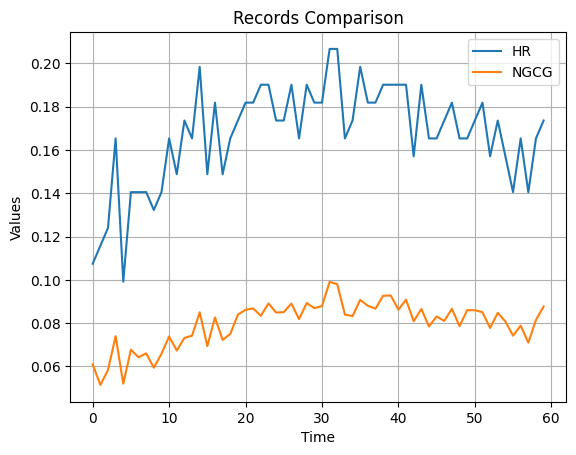

In [ ]:
import matplotlib.pyplot as plt

# x축 데이터 (시간이나 인덱스 등)
x = range(len(records_hr))

# 꺽은선 그래프 그리기
plt.plot(x, records_hr, label='HR'
  #, marker='o'
  )
plt.plot(x, records_ngcg, label='NGCG'
  #, marker='s'
  )

# 그래프 제목 및 축 레이블
plt.title('Records Comparison')
plt.xlabel('Time')
plt.ylabel('Values')

# 범례 추가
plt.legend()

# 그래프 보여주기
plt.grid()
plt.show()

#GMF 층을 결합하지 않은 MLP-based NCF
